In [ ]:
!pip install dtreeviz

In [34]:
# box cox transform
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np

The data, descriptions of the variables and some examples can be found here:
[house-pricese-from-kaggle-competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

In [35]:
!pwd

/home/martin/python/fhnw_lecture/notebooks


### data is from a kaggle-competition
Attention, the test data-set has no target; This is the part you are supposed to upload to kaggle for estimation of your modelling performance;

In [36]:
train = pd.read_csv('../data/train.csv', sep=",")
test = pd.read_csv('../data/test.csv')

train_ID = train['Id']
test_ID = test['Id']

train.drop('Id', axis = 1, inplace = True)
test.drop('Id', axis = 1, inplace = True)

SalePrice = train['SalePrice']
train.drop('SalePrice', axis=1, inplace = True)

### now, we want data-leakage
We discussed at length, that train and test-set should be standardized and preprocessed independently; This is only true if we want a fair estimate of our algorithm's performance with new, unseen data.<br>
In the current case we want our training-procedure to be biased towards the test-set, because the test-set performance is what counts in kaggle-competitions.

In [4]:
data = pd.concat((train, test))
data.reset_index(drop = True, inplace = True)
# categorical and numericalvariables:

categorical = [var for var in train.columns if train[var].dtype=='O']
numerical = [var for var in train.columns if train[var].dtype!='O']

# Some preprocessing steps
### we fill missing values with the mean and add an extra variable indicating the missing position

In [5]:
data[categorical] = data[categorical].fillna('None')


## next, we substitute missing values with the mean of the variable and form new variables
## indicating the missing values. Sometimes data is not missing at random and the fact that
## data is missing might contain valuable information
variables_na = []
for val in numerical:
    data[val + '_na'] = pd.isnull(data[val])
    variables_na.append(val + '_na')
    data[val].fillna(data[val].mean(), inplace = True)


/tmp/ipykernel_47978/4085472443.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[val].fillna(data[val].mean(), inplace = True)
/tmp/ipykernel_47978/4085472443.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

### we transform the continuous variables to be more normally distributed
[box-cox transform in short](https://www.statisticshowto.com/box-cox-transformation/#:~:text=A%20Box%20Cox%20transformation%20is,a%20broader%20number%20of%20tests.)

In [6]:
## box-cox transform is variance stabilizing. It is meant to make 
## the variable more normaly distributed    
box_cox = []
for val in numerical:
    new_vals, lamb = boxcox(data[val] + 1)
    if np.abs(lamb) < 8:
        data[val + '_box_cox'] = new_vals
        box_cox.append(val)

        

/tmp/ipykernel_47978/3204645832.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[val + '_box_cox'] = new_vals
/tmp/ipykernel_47978/3204645832.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[val + '_box_cox'] = new_vals
/tmp/ipykernel_47978/3204645832.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

### we demonstrate the effect of the box-cox transform

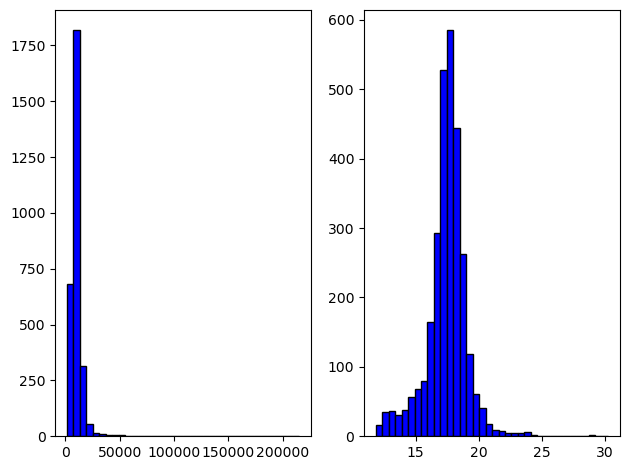

In [7]:
from matplotlib import pyplot as plt
var = 'LotArea'
# 2 fitures
ax = plt.subplot(1, 2, 1)
# non-transformed variable    
ax.hist(data[var], bins = int(180/5),
         color = 'blue', edgecolor = 'black')

ax = plt.subplot(1, 2, 2)
# transformed_variable
ax.hist(data[var + '_box_cox'], bins = int(180/5),
         color = 'blue', edgecolor = 'black')
plt.tight_layout()
plt.show()

### we encode categorical data as dummy-variables (aka one-hot encoding)

In [8]:
# as already announced, categorical data is one-hot encoded (dummy-coded)  

data_base = pd.get_dummies(data[[col for col in data.columns if col not in variables_na]])
data_na = pd.get_dummies(data[variables_na])

# we have to cast every variable's data type to float32 for our next 'trick' 
data_base = data_base.astype(np.float32)
data_na = data_na.astype(np.float32)
data_numerical = data[numerical]

data = pd.concat([data_base, data_na], axis = 1)

### we compute the feature importance in order to get the most relevant variable
With this trick we identify the most relevant variables. Like this, we are adding interaction-terms only for the most relevant variables.

In [9]:
# the number of variables is quiet high. We want to add interaction terms for the most important
# variables. Therefore, we want to compute some variable-importance measure. This is
# done by the help of gradient boosted trees:
gbm = GradientBoostingRegressor(n_estimators = 32, max_depth = 4)
gbm.fit(data.iloc[0:len(train_ID)].values, SalePrice.values)

GradientBoostingRegressor(max_depth=4, n_estimators=32)

In [10]:
from sklearn.inspection import permutation_importance

# we sort the variables (indizes) by variable importance
indizes = np.argsort(gbm.feature_importances_)
result = permutation_importance(gbm, data.iloc[0:len(train_ID)], SalePrice, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  

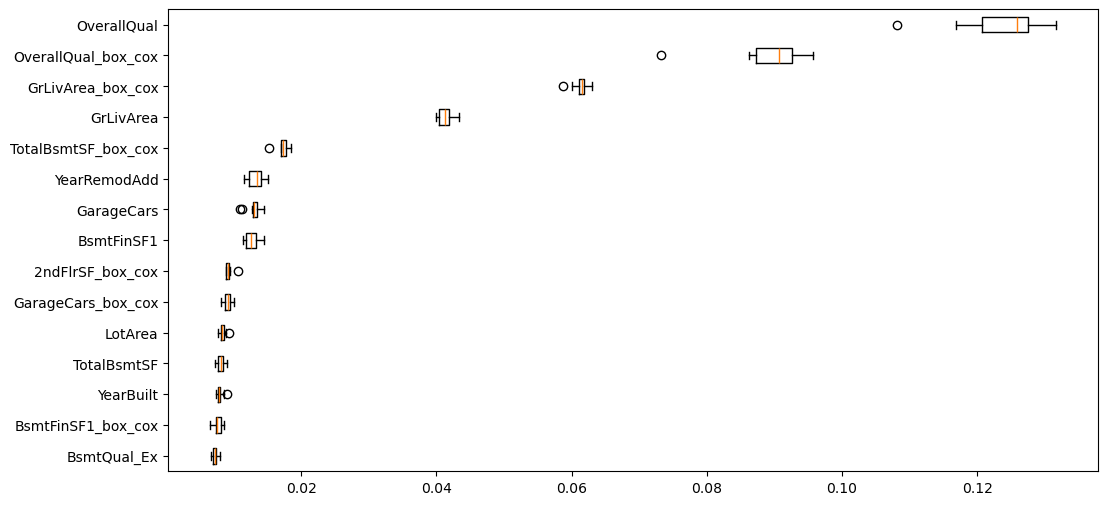

In [11]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 1, 1)
plt.boxplot(result.importances[sorted_idx[-15:]].T,
            vert=False, labels=np.array(data.columns)[sorted_idx[-15:]])
fig.show()

## for the most important features we compute the interactions
### in the first step we include only the most important 15 variables to form interaction-terms

In [12]:
# import a tool for getting all possible n over 2 combinations of these variables
from itertools import combinations
# and add the interactions
interactions = []
for comb in list(combinations(data.columns[sorted_idx[-15:]], 2)):
    data[comb[0] + '_x_' + comb[1]] = data[comb[0]] * data[comb[1]]
    interactions.append(comb[0] + '_x_' + comb[1])

data_interactions = data[interactions]

/tmp/ipykernel_47978/1353596089.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[comb[0] + '_x_' + comb[1]] = data[comb[0]] * data[comb[1]]
/tmp/ipykernel_47978/1353596089.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[comb[0] + '_x_' + comb[1]] = data[comb[0]] * data[comb[1]]
/tmp/ipykernel_47978/1353596089.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(

### in the second step we include even 55 variables to form interactions

In [13]:
interactions2 = []
for comb in list(combinations(data.columns[sorted_idx[-55:]], 2)):
    data[comb[0] + '_x_' + comb[1]] = data[comb[0]] * data[comb[1]]
    interactions2.append(comb[0] + '_x_' + comb[1])

data_interactions2 = data[interactions2]

/tmp/ipykernel_47978/305782326.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[comb[0] + '_x_' + comb[1]] = data[comb[0]] * data[comb[1]]
/tmp/ipykernel_47978/305782326.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[comb[0] + '_x_' + comb[1]] = data[comb[0]] * data[comb[1]]
/tmp/ipykernel_47978/305782326.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axi

/tmp/ipykernel_47978/305782326.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[comb[0] + '_x_' + comb[1]] = data[comb[0]] * data[comb[1]]
/tmp/ipykernel_47978/305782326.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[comb[0] + '_x_' + comb[1]] = data[comb[0]] * data[comb[1]]
/tmp/ipykernel_47978/305782326.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axi

In [14]:
## 1.
# now, we have different data sets
# the base set with missing values imputed by the mean and no other feature engineering
# box-cox transformed variables are removen
base = data_base[[col for col in data_base.columns if not col.endswith('_box_cox')]]
## 2.
# box_cox is admitted; original variables removed
with_box_cox = data_base[[col for col in data_base.columns if not col in box_cox]]
## 3.
# variables indicating formerly missing values are included
with_na = pd.concat([with_box_cox, data_na], axis = 1)
## 4.
# all interaction terms of the 55 most important variables are added
with_interactions = pd.concat([with_na, data_interactions], axis = 1)
## 5.
## we exagerate the number of interactions
with_interactions2 = pd.concat([with_na, data_interactions2], axis=1)
## the target variable is log-transformed
y = np.log1p(SalePrice)

## since we want to try elasticnet, we have to find the optimal parameter for 
# lambda (amount of regularization) and for alpha (ratio of lasso and ridge mixing)
lamb = 10**(np.linspace(-1, 0.2, 15))
# ratio
ratio = np.linspace(0, 1, 10)

### excurs: parameter sampling on a logarithmic scale

sample some of the parameters on a logrithmic scale:
https://www.coursera.org/lecture/deep-neural-network/using-an-appropriate-scale-to-pick-hyperparameters-3rdqN

$b^y = x; \; y = log_b(x)$

In [15]:
np.linspace(0.0001, 0.1, 5) # 5 equally spaced values from 0.0001 to 0.1

array([0.0001  , 0.025075, 0.05005 , 0.075025, 0.1     ])

As you can see, there is no value between 0.0001 and 0.001 and no value between 0.001 and 0.01. But there are three values between 0.01 and 0.1<br>
Now, compare to this solution:

In [16]:
10**np.linspace(-4, -1, 5)

array([0.0001    , 0.00056234, 0.00316228, 0.01778279, 0.1       ])

### we transform the SalePrice (y) as well

In [17]:
# the function np.log1p is well defined at 0
display(np.log(0), np.log(1), np.log(2),
        np.log1p(1), np.log1p(0))

/tmp/ipykernel_47978/991790603.py:2: RuntimeWarning: divide by zero encountered in log
  display(np.log(0), np.log(1), np.log(2),


-inf

0.0

0.6931471805599453

0.6931471805599453

0.0

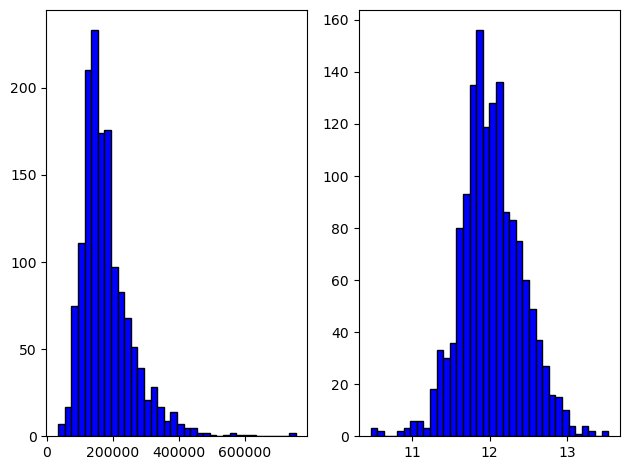

In [18]:
ax = plt.subplot(1, 2, 1)
# non-transformed variable    
ax.hist(SalePrice, bins = int(180/5),
         color = 'blue', edgecolor = 'black')

ax = plt.subplot(1, 2, 2)
# transformed_variable
ax.hist(np.log1p(SalePrice), bins = int(180/5),
         color = 'blue', edgecolor = 'black')
plt.tight_layout()
plt.show()

### polynomial features
We can even do more. The function `sklearn.preprocessing.PolynomialFeatures`generates all polynomials of a certain degree; for example, if the degree = 2 and there are two variables (a and b) it generates all $a, b, a\cdot b, a^2\,\, \text{and}\,\,  b^2$ terms.

In [19]:
from sklearn.preprocessing import PolynomialFeatures
pl = PolynomialFeatures(3, interaction_only = False, include_bias=False)

In [20]:
polies = pl.fit_transform(data[data.columns[sorted_idx[-15:]]])
X_polynomial = pd.concat([with_na, pd.DataFrame(polies,columns = [str(i) for i in range(polies.shape[1])])], axis=1)

In [21]:
with_box_cox.columns

Index(['YearBuilt', 'YearRemodAdd', 'LowQualFinSF', 'BsmtHalfBath',
       '3SsnPorch', 'PoolArea', 'YrSold', 'MSSubClass_box_cox',
       'LotFrontage_box_cox', 'LotArea_box_cox',
       ...
       'SaleType_New', 'SaleType_None', 'SaleType_Oth', 'SaleType_WD',
       'SaleCondition_Abnorml', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=310)

In [22]:
error = []
best_parameters = []
# we iterate over list of data-sets
# X_polynomial,
for d in [base, with_box_cox, with_na, with_interactions, X_polynomial,  with_interactions2]:
# for d in [with_interactions, X_polynomial]:
    # scale variables
    scaler = StandardScaler()
    scaler.fit(d[:len(train_ID)]) #  fit  the scale        

    X_train = scaler.transform(d[:len(train_ID)])
    X_test = scaler.transform(d[len(train_ID):])
    
    # the function cross_val_score computes the model passed to it for cv=5-fold 
    # cross validation; we compute the mean over the 5 folds
    get_results = [(la, r, np.mean(np.sqrt(-cross_val_score(ElasticNet(alpha = la,
                                                            l1_ratio = r),
            X_train, y , scoring = 'neg_mean_squared_error',
            cv = 5, n_jobs = -1))))
                for la in lamb for r in ratio]
    
    # the least error is extracted
    least_error = np.min([i[2] for i in get_results])
    error.append(least_error)
    # the parameters belonging to the best result
    parameters = [i[0:2] for i in get_results if i[2] == least_error]
    best_parameters.append(parameters)
    print(f'least error is: {least_error}, best parameters are: {parameters}')


/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.878e+00, tolerance: 1.891e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.055e+00, tolerance: 1.800e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted usi

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.356e+00, tolerance: 1.837e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.963e+00, tolerance: 1.891e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted usi

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.020e+00, tolerance: 1.881e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.610e+00, tolerance: 1.891e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted usi

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.105e+01, tolerance: 1.800e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.150e+01, tolerance: 1.837e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted usi

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.538e+01, tolerance: 1.901e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.498e+01, tolerance: 1.837e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted usi

least error is: 0.13822808131208597, best parameters are: [(0.3981071705534972, 0.0)]


/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.017e+00, tolerance: 1.800e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.694e+00, tolerance: 1.891e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted usi

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.054e+00, tolerance: 1.800e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.700e+00, tolerance: 1.901e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted usi

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.379e+00, tolerance: 1.891e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.303e+00, tolerance: 1.901e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted usi

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.179e+01, tolerance: 1.891e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.098e+01, tolerance: 1.800e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted usi

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.530e+01, tolerance: 1.891e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.439e+01, tolerance: 1.800e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted usi

least error is: 0.13065759218112855, best parameters are: [(0.1, 0.1111111111111111)]


/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.683e+00, tolerance: 1.891e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.010e+00, tolerance: 1.800e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted usi

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.047e+00, tolerance: 1.800e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.697e+00, tolerance: 1.901e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted usi

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.372e+00, tolerance: 1.891e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.907e+00, tolerance: 1.881e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted usi

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.168e+01, tolerance: 1.901e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.179e+01, tolerance: 1.891e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted usi

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.468e+01, tolerance: 1.837e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.456e+01, tolerance: 1.881e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted usi

least error is: 0.13065758899111907, best parameters are: [(0.1, 0.1111111111111111)]


/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.820e+00, tolerance: 1.891e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.628e+00, tolerance: 1.881e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted usi

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.490e+00, tolerance: 1.891e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.828e+00, tolerance: 1.800e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted usi

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.421e+00, tolerance: 1.901e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.925e+00, tolerance: 1.837e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted usi

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.884e+00, tolerance: 1.891e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.807e+00, tolerance: 1.901e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted usi

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.073e+01, tolerance: 1.901e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.084e+01, tolerance: 1.891e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted usi

least error is: 0.12743868091096364, best parameters are: [(0.12181879120101156, 0.0)]


/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.144e+00, tolerance: 1.881e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.331e+00, tolerance: 1.901e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted usi

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.638e-02, tolerance: 1.837e-02
  model = cd_fast.enet_coordinate_descent(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.111e-02, tolerance: 1.891e-02
  model = cd_fast.enet_coordinate_descent(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.193e-02, tolerance: 1.837e-02
  model = cd_fast.enet_coordinate_descent(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.662e+00, tolerance: 1.891e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-pa

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.624e-02, tolerance: 1.901e-02
  model = cd_fast.enet_coordinate_descent(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.961e-02, tolerance: 1.837e-02
  model = cd_fast.enet_coordinate_descent(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.973e-02, tolerance: 1.881e-02
  model = cd_fast.enet_coordinate_descent(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.108e-02, tolerance: 1.837e-02
  model = cd_fast.enet_coordinate_descent(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.264e-02, tolerance: 1.901e-02
  model = cd_fast.enet_coordinate_descent(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.055e-02, tolerance: 1.837e-02
  model = cd_fast.enet_coordinate_descent(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.889e-02, tolerance: 1.800e-02
  model = cd_fast.enet_coordinate_descent(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.048e+00, tolerance: 1.837e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-pa

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.980e+00, tolerance: 1.800e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.649e+00, tolerance: 1.891e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted usi

least error is: 0.12159654873397648, best parameters are: [(0.8767123872968682, 0.0)]


/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.513e+00, tolerance: 1.800e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.797e+00, tolerance: 1.901e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted usi

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.902e-02, tolerance: 1.881e-02
  model = cd_fast.enet_coordinate_descent(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.076e+00, tolerance: 1.800e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-pa

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.701e+00, tolerance: 1.837e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.017e+00, tolerance: 1.891e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted usi

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.857e+00, tolerance: 1.881e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.900e+00, tolerance: 1.891e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted usi

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.837e+00, tolerance: 1.881e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.978e+00, tolerance: 1.891e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted usi

least error is: 0.12041096696738114, best parameters are: [(0.3981071705534972, 0.0)]


In [23]:
error

[0.13822808131208597,
 0.13065759218112855,
 0.13065758899111907,
 0.12743868091096364,
 0.12159654873397648,
 0.12041096696738114]

In [24]:
best_parameters

[[(0.3981071705534972, 0.0)],
 [(0.1, 0.1111111111111111)],
 [(0.1, 0.1111111111111111)],
 [(0.12181879120101156, 0.0)],
 [(0.8767123872968682, 0.0)],
 [(0.3981071705534972, 0.0)]]

In [25]:
# more variables than training examples, but best cross-validation result:
with_interactions2[:len(train_ID)].shape

(1460, 1831)

We conclude:
1. The error for the base data set (only missing values imputed) is: {{np.round(error[0], 4)}}  (mse); The corresponding lambda is {{np.round(best_parameters[0][0][0], 4)}}, i.e. the amount of regularization; the l1_ratio = {{np.round(best_parameters[0][0][1], 4)}}; the kind of regularization was pure ridge (l2-penalty)
2. The error with some of the numeric variables box-cox transformed is {{np.round(error[1], 4)}} (mse); the amount of regularization is far less than before ({{np.round(best_parameters[1][0][0], 4)}}); we have {{np.round(best_parameters[1][0][1] * 100)}}% l1-penalty and {{np.round(100 - (best_parameters[1][0][1] * 100))}}% l2-penalty
3. Indicator variables for formerly missing values are included in the data-set; The error ({{np.round(error[2], 4)}}) shrinks by an insignificant amount. The lambda parameter is {{np.round(best_parameters[2][0][0], 4)}}; no l1-penalty is used
4. adding the interaction terms has the most pronounced effect. The error drops to {{np.round(error[3], 4)}}; The best parameters are as before.

One additional note: By including the interaction2 terms, we have __more variables (1831) than observations (1460)__ in the training set. This situation is not admissable in classical statistics. For machine learning algorithms with regularization and/or iterative optimization, it does not mean any problem.

## Now, we are doing all the processing steps withing a pipeline
this can prevent overfitting as we will see later.<br>

We are not adding interaction-terms here; 

One-hot encoding and adding variables for missing values is not critical: no statistics are fitted<br>

we load the data (only train) once again:

In [26]:
train = pd.read_csv('../data/train.csv', sep=",")
train_ID = train['Id']
train.drop('Id', axis = 1, inplace = True)
SalePrice = train['SalePrice']
train.drop('SalePrice', axis=1, inplace = True)
categorical = [var for var in train.columns if train[var].dtype=='O']
numerical = [var for var in train.columns if train[var].dtype!='O']

Next we add an indicator variable for every missing value: no statistics are fitted:

In [27]:
train[categorical] = train[categorical].fillna('None')
for val in numerical:
    train[val + '_na'] = pd.isnull(train[val])

the follwing statistics however, depend on the data:<br>
- filling NAs with mean-values
- box-cox transform of variable
- fitting the model

In [29]:
import sys
import os
import numpy as np
sys.path.append(os.path.abspath('../scripts'))
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder


numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scaler', PowerTransformer(method='box-cox'))])

categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical),
        ('cat', categorical_transformer, categorical),
        ])

clf = GridSearchCV(
        make_pipeline(
            preprocessor,
            ElasticNet()
            ),
            param_grid={'elasticnet__alpha': 10**(np.linspace(-1, 0.2, 5)),
                        'elasticnet__l1_ratio': np.linspace(0, 1, 6)},
         cv=5, refit=False, scoring = 'neg_mean_squared_error'
)


In [30]:
train[numerical] += 1
clf.fit(train, np.log1p(SalePrice))

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.120e+01, tolerance: 1.891e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.019e+01, tolerance: 1.800e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted usi

/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.025e+01, tolerance: 1.891e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/martin/miniconda3/envs/imbalanced/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.891e+01, tolerance: 1.800e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted usi

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          PowerTransformer(method='box-cox'))]),
                                                                         ['MSSubClass',
                                                                          'LotFrontage',
                                                                          'LotArea',
                                                                          'OverallQual',
                                                                          'OverallCond',
                                                                          'YearBuilt',
                                                                          'YearRemodAdd',
                                                                          'MasVnrArea',
                                                                          'BsmtFinSF1',
                                                                          'BsmtFinSF2',
                                                                          'BsmtUnfSF',
                                                                          'TotalBsmt...
                                                                          'Foundation',
                                                                          'BsmtQual',
                                                                          'BsmtCond',
                                                                          'BsmtExposure',
                                                                          'BsmtFinType1',
                                                                          'BsmtFinType2',
                                                                          'Heating',
                                                                          'HeatingQC',
                                                                          'CentralAir',
                                                                          'Electrical', ...])])),
                                       ('elasticnet', ElasticNet())]),
             param_grid={'elasticnet__alpha': array([0.1       , 0.19952623, 0.39810717, 0.79432823, 1.58489319]),
                         'elasticnet__l1_ratio': array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])},
             refit=False, scoring='neg_mean_squared_error')

In [31]:
display(clf.best_params_, np.sqrt(-clf.best_score_))
# clf.cv_results_.keys()

{'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 0.0}

0.13237803319111607

In [32]:
clf.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_elasticnet__alpha', 'param_elasticnet__l1_ratio', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [33]:
np.sqrt(-clf.cv_results_['mean_test_score'])

array([0.13237803, 0.1493028 , 0.16540801, 0.18267359, 0.19985306,
       0.21528227, 0.13500173, 0.168074  , 0.20169271, 0.23435203,
       0.26753428, 0.299449  , 0.13929797, 0.2067523 , 0.27600369,
       0.33904176, 0.39445307, 0.39954338, 0.14674367, 0.28669422,
       0.39540082, 0.39954338, 0.39954338, 0.39954338, 0.16027503,
       0.39657224, 0.39954338, 0.39954338, 0.39954338, 0.39954338])

# Reminder
We found the best parameters via extensive search over the whole data-set. As we have discussed, theoretically nested-cross-validation (aka double-cross-validation) would have been the better choice. However, it would also be computationally more expensive.